# Introduction

__Background__<br>
Due of the COVID-19 pandemic, Metro Manila, Philippines has been under quarantine since March 2020. Quarantine restrictions made it difficult for most businesses to operate, but these also greatly increased the demand for delivery services because it is unsafe to go out in public places.
Since large delivery fees are unattractive to most customers, some businesses offer free delivery to certain areas, usually exclusive villages, if they have many customers in that area. These businesses often have a Viber chat group for each village, where residents send their orders. 
This delivery model works well for businesses that sell essential, perishable goods such as vegetables and meat because these are items that are bought frequently and by the same customers.

__Target Market__<br>
This report is targeted towards stakeholders who are interested in starting a perishable goods delivery business that caters to residents in exclusive villages in Metro Manila, Philippines.

__Business Problem__<br>
If deliveries are done 6 days a week, how could one know which villages to deliver to each day to optimize their logistics, and from which wet market supplier to get the perishable goods from?

# Data

__Data Needed__<br>
Based on the definition of the problem, here are the factors that will influence the decision:<br>
1. The locations of the exclusive villages in Metro Manila<br>
2. The names and ratings of wet markets nearest to each delivery group (since the customers are usually picky with the quality of the goods that they buy)<br>

__Data Sources__<br>
The following data sources will be used to extract or generate the required information:<br>
1. __Nominatim API geocoding__ – for finding the longitude and latitude of each exclusive village in Metro Manila <br>
2. __Foursquare API__ – for determining the wet markets around the areas of the exclusive villages and their ratings <br>
3. __List of exclusive residential areas in Metro Manila from one of the top bread shops in the country that delivers to these villages__ – for identifying the exclusive villages which the target market will be delivering to <br>
- The residents of the villages listed here are the same ones the target market would want to attract. <br>
- This is public information because this list is available on the bread shop’s online order form.


# Methodology

__Gather data and import libraries needed__<br>
One of the top bread shops in the country delivers bread weekly to the most exclusive villages in Metro Manila. The residential areas that they deliver to are included in their online order form, since customers will have to select the village where they live.
I took note of these 45 areas and consolidated each village’s longitude and latitude in a CSV file, which I got from using Nominatim API geocoding. I will import this file later on.

Now I will import the libraries needed.

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

import json #library to parse JSON files into a Python dictionary or list

import matplotlib.cm as cm # library for plotting points in the map
import matplotlib.colors as colors #library for plotting points in the map

from pandas.io.json import json_normalize # library for tranforming json files into a pandas dataframe library

!python3 -m pip install folium

import folium # library for creating maps
from geopy.geocoders import Nominatim # library for geocoding the longitude and latitude of different areas needed

from sklearn.cluster import KMeans # library for creating a k-means clustering model

print('Libraries imported.')

Libraries imported.


After this, I will input my Foursquare credentials because I will be requesting for data from Foursquare API later on. I will also upload the CSV file of village data into this notebook.

In [2]:
#Foursquare credentials (hidden cell)

# @hidden_cell

CLIENT_ID = 'RSC3G0GMLOJSBAD0PM1CDGKHBJIO441GM32W4RMZ4EG2HXFL' # Foursquare ID
CLIENT_SECRET = 'QR5FE44FD3AKMH3HRHINEHH4FTOWIPROJB42S02G41NLQE3S' # Foursquare Secret
ACCESS_TOKEN = 'AGWAV4YZA0YDWA1CIRQPDLXLXO0XUAC0YRBQ5EVYJTBLHA53'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [3]:
#upload village longitude and latitude data
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_72bb2cc2bf394f808e906b2846065a96 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='2yAi6af8qHPbiTRiTT__grS8S4UTQOgmbgm0JRcZmc7c',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_72bb2cc2bf394f808e906b2846065a96.get_object(Bucket='datasciencecapstoneproject-donotdelete-pr-qnzvpggrjpjdlo',Key='MM Village Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_villages = pd.read_csv(body)
df_villages.head()


Village   Latitude   Longitude
0       53 BENITEZ  14.614629  121.046274
1        ACROPOLIS  14.605744  121.077077
2        ALEXANDRA  14.580917  121.062601
3  APARTMENT RIDGE  14.556622  121.026340
4    AYALA ALABANG  14.405740  121.023723

__Visualize village locations__<br>
I want to visualize where the villages are in relation to each other on the map of Metro Manila. To do this, I first have to get the latitude and longitude of Metro Manila and then use the Folium library to generate a map. The villages will be plotted onto the map as blue points.

In [4]:
#get latitude and longitude of Metro Manila

address = 'Metro Manila'

geolocator = Nominatim(user_agent="mm_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

14.5736108 121.0329706


In [5]:
# generate map of villages in Metro Manila

village_map = folium.Map(location=[latitude, longitude], zoom_start=13) 

# add the villages as blue circle markers
for Latitude, Longitude, label in zip(df_villages.Latitude, df_villages.Longitude, df_villages.Village):
    folium.CircleMarker(
        [Latitude, Longitude],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(village_map)

# display map
village_map

At first glance, I could see that most villages were located in the center of Metro Manila, while there were a few outliers in the north and south. From here, it looks like there are 4 possible village clusters, but since there are 6 working days a week for delivery, I want to split all these villages into 6 clusters.

__K-Means clustering of villages__<br>
Because the goods being delivered are perishable and could spoil easily, only residents in villages near each other should be delivered to in one day.
The k-means clustering model is used to group the unlabeled data based on their proximity to each other; in this case, the different villages. After the dataset is divided into 6 groups, a new column will be added to the dataframe for the cluster labels.

In [6]:
#get k-means clusters of Metro Manila exclusive villages
#6 clusters because one cluster for each working day of the week

kclusters = 6
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_villages[["Latitude", "Longitude"]])

kmeans.labels_[0:10] 

array([0, 4, 4, 5, 1, 3, 1, 5, 4, 4], dtype=int32)

In [7]:
#add cluster labels to dataframe

df_villages.insert(0, 'Cluster Labels', kmeans.labels_)

In [8]:
df_villages.head()

Cluster Labels          Village   Latitude   Longitude
0               0       53 BENITEZ  14.614629  121.046274
1               4        ACROPOLIS  14.605744  121.077077
2               4        ALEXANDRA  14.580917  121.062601
3               5  APARTMENT RIDGE  14.556622  121.026340
4               1    AYALA ALABANG  14.405740  121.023723

To visualize the clusters, a new map will be created where each cluster label will be assigned a specific color and plotted on a map using folium.

In [9]:
#map the clusters
cluster_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# set colors for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
centers = kmeans.cluster_centers_

# put markers
cluster_markers = []
for lat, lon, village, cluster in zip(df_villages['Latitude'], df_villages['Longitude'], df_villages['Village'], df_villages['Cluster Labels']):
    label = folium.Popup(str(village) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
       
cluster_map

# Results and Analysis

Now that it was clear which villages would be delivered to on the same day, a specific wet market had to be assigned to each village cluster as to minimize the amount of travel time the goods will have to go through during delivery. It is important that the wet markets chosen are as close as possible to the clusters, especially if there are customers who order seafood or other produce that spoils easily. 

Farmers Market in Cubao, Quezon City is one of the more high-end wet markets in Metro Manila where residents of these exclusive villages often get their fresh produce. For this reason, __I will not search for wet markets around the areas of Clusters 0 and 4 anymore__, since Farmers Market is situated in between these clusters. This will be the wet market supplier for villages in these clusters because 1) it already has a good reputation and 2) "_suki_" culture in the Philippines means that wet market vendors usually give lower prices to customers who consistently buy from their stalls. Because the target market will be buying goods from the same stalls in Farmers Market for the residents of these two clusters, prices would be minimized as well.

I will only be searching then for the best wet markets to supply villages in Clusters 1, 2, 3, and 5.

### Finding wet market supplier candidates for Cluster 1
Because Cluster 1 only includes 2 villages (Ayala Alabang and Ayala Southvale), I picked one to use as reference for finding wet markets near Cluster 1, and this will be the first village to be delivered to.

In [10]:
#get latitude and longitude of Ayala Alabang Village

address_1 = 'Ayala Alabang, Metro Manila'

geolocator_1 = Nominatim(user_agent="1_agent")
location_1 = geolocator_1.geocode(address_1)
latitude_1 = location_1.latitude
longitude_1 = location_1.longitude
print(latitude_1, longitude_1)

14.4158464 121.024634


In [11]:
#search wet markets near each selected address

search_query = 'wet market'
radius = 2000
print(search_query)

wet market


In [12]:
#define the url to find wet markets near Cluster 1

url_1 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_1, longitude_1,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url_1

'https://api.foursquare.com/v2/venues/search?client_id=RSC3G0GMLOJSBAD0PM1CDGKHBJIO441GM32W4RMZ4EG2HXFL&client_secret=QR5FE44FD3AKMH3HRHINEHH4FTOWIPROJB42S02G41NLQE3S&ll=14.4158464,121.024634&oauth_token=AGWAV4YZA0YDWA1CIRQPDLXLXO0XUAC0YRBQ5EVYJTBLHA53&v=20180605&query=wet market&radius=2000&limit=100'

In [13]:
#get the results of wet markets near Cluster 1

results_1 = requests.get(url_1).json()
results_1

{'meta': {'code': 200, 'requestId': '6021f119a69b7c2919e88b6c'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4d9c0f8381f6f04d521682aa',
    'name': 'Alabang Public Market',
    'location': {'lat': 14.420129025142451,
     'lng': 121.04455969423788,
     'labeledLatLngs': [{'label': 'display',
       'lat': 14.420129025142451,
       'lng': 121.04455969423788}],
     'distance': 2200,
     'cc': 'PH',
     'city': 'Muntinlupa',
     'state': 'Rizal',
     'country': 'Pilipinas',
     'formattedAddress': ['Muntinlupa City', 'Rizal']},
    'categories': [{'id': '50be8ee891d4fa8dcc7199a7',
      'name': 'Market',
      'pluralName': 'Markets',
      'shortName': 'Market',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/market_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1612837145',
    'hasPerk': False},
   {'id': '4d4a54e24509721e71252db0',
    'name': "Gourdo's World M

In [14]:
# assign relevant part of JSON to venues
venues_1 = results_1['response']['venues']

# tranform venues into a dataframe
df_results_1 = json_normalize(venues_1)
df_results_1

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


id  \
0   4d9c0f8381f6f04d521682aa   
1   4d4a54e24509721e71252db0   
2   57f5c417498e2f861592344e   
3   4b9b4631f964a520b2fd35e3   
4   5528d131498e4a1cb5aacaf6   
5   4d5efa01b19fa14358f7e0c8   
6   59d86dca2347246fede29682   
7   5df4a01411ae5100084e5c78   
8   4c04a20173a8c9b6206196e0   
9   4d30e9498ece8cfa6f7dc0a4   
10  4c385f363849c9288f54bfb1   
11  4eb1df21490126a570052b42   
12  4bb1d6daf964a520b7a53ce3   
13  500749dce4b0aa85886904c4   
14  4dca6fcb887769ff3d4de724   
15  50ab2b07e4b068b459279149   
16  57342e74498e58f5e653ac06   
17  517915c6e4b0e8859321af5c   
18  5038d4ebe4b01fa3529f1747   
19  4fa47885e4b01208f9fafb9c   
20  55ecc842498e2b63b57ffdc1   
21  55f0bf74498edd83076fb4c3   
22  516478b7e4b00638ee573446   
23  5032cf79e4b012c9cf5b18f5   
24  566beac0498e7d638e82b036   
25  4ed46fcf30f803fae72c281c   
26  4f688e16e4b005342b04fc7b   
27  4b9c7413f964a520d96936e3   
28  530746b111d2bb1a8b423039   
29  5886f37124fd71634798d256   
30  5125ab52e4b05c4d0a733521   
31  59e5cd79625a6608697d793a   
32  53461249498e860024c5ae28   
33  5376e71a498e2b3f9db4c8c2   
34  55f787f8498ed2a46121bd01   
35  5332c02f498efb598e0ede01   

                                                 name  \
0                               Alabang Public Market   
1                               Gourdo's World Market   
2                    Mongolian Quick-Box / Pho Market   
3                                   South Supermarket   
4                Saturday Market on University Avenue   
5                            Filinvest Corporate City   
6                                       Shorts Market   
7                        Christmas Calle Night Market   
8                          Filinvest Marketing Office   
9                                     Saturday Market   
10                               Earle's Delicatessen   
11                     Intermed Marketing Philippines   
12                                                KFC   
13                                     TS Cruz Market   
14                              Gourdo's World Market   
15                                         HDR Market   
16                      festival mall's summer market   
17                                    Moonwalk Market   
18              7 Eleven, Caltex, Wetparc Condominium   
19            Saturday market university ave. Lasalle   
20                               Pilar Village Market   
21                               Pilar Village Market   
22                    711 Market Dr Filinvest Alabang   
23            Filinvest Marketing Office, Parking Lot   
24                                         MotoMarket   
25                               Almanza Market Dampa   
26                                  7-11 Market Drive   
27                        Muntinlupa Poblacion Market   
28                                      Market Basket   
29  APEX (Admin Project Experts) Marketing Consult...   
30          Filinvest Corporate City Marketing Office   
31                    Earthorigins Marketplace + Cafe   
32                           Out Of The Box Marketing   
33                          Bio Generra Marketing Inc   
34                              Soldiers Hills Market   
35                         Market Basket Modern Dampa   

                                           categories    referralId  hasPerk  \
0   [{'id': '50be8ee891d4fa8dcc7199a7', 'name': 'M...  v-1612837145    False   
1   [{'id': '4bf58dd8d48988d127951735', 'name': 'A...  v-1612837145    False   
2   [{'id': '4eb1d5724b900d56c88a45fe', 'name': 'M...  v-1612837145    False   
3   [{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...  v-1612837145    False   
4   [{'id': '4bf58dd8d48988d143941735', 'name': 'B...  v-1612837145    False   
5   [{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...  v-1612837145    False   
6   [{'id': '4bf58dd8d48988d103951735', 'name': 'C...  v-1612837145    False   
7   [{'id': '53e510b7498ebcb1801b55d4', 'name': 'N...  v-1612837145    False   
8   [{'id':

Now that there is a list of wet markets near Cluster 1, the data would have to be cleaned up so it is easier to understand.

In [15]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns_1 = ['name', 'categories'] + [col for col in df_results_1.columns if col.startswith('location.')] + ['id']
df_markets_1 = df_results_1.loc[:, filtered_columns_1]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_markets_1['categories'] = df_markets_1.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_markets_1.columns = [column.split('.')[-1] for column in df_markets_1.columns]

df_markets_1

name            categories  \
0                               Alabang Public Market                Market   
1                               Gourdo's World Market   Arts & Crafts Store   
2                    Mongolian Quick-Box / Pho Market  Mongolian Restaurant   
3                                   South Supermarket           Supermarket   
4                Saturday Market on University Avenue        Breakfast Spot   
5                            Filinvest Corporate City          Neighborhood   
6                                       Shorts Market        Clothing Store   
7                        Christmas Calle Night Market          Night Market   
8                          Filinvest Marketing Office    Real Estate Office   
9                                     Saturday Market                  None   
10                               Earle's Delicatessen         Deli / Bodega   
11                     Intermed Marketing Philippines                Office   
12                                                KFC  Fast Food Restaurant   
13                                     TS Cruz Market        Farmers Market   
14                              Gourdo's World Market                  None   
15                                         HDR Market               Butcher   
16                      festival mall's summer market           Flea Market   
17                                    Moonwalk Market                  None   
18              7 Eleven, Caltex, Wetparc Condominium           Snack Place   
19            Saturday market university ave. Lasalle                Market   
20                               Pilar Village Market                Market   
21                               Pilar Village Market                Market   
22                    711 Market Dr Filinvest Alabang     Convenience Store   
23            Filinvest Marketing Office, Parking Lot               Parking   
24                                         MotoMarket       Motorcycle Shop   
25                               Almanza Market Dampa    Seafood Restaurant   
26                                  7-11 Market Drive     Convenience Store   
27                        Muntinlupa Poblacion Market         Grocery Store   
28                                      Market Basket   Filipino Restaurant   
29  APEX (Admin Project Experts) Marketing Consult...                Market   
30          Filinvest Corporate City Marketing Office              Building   
31                    Earthorigins Marketplace + Cafe       Organic Grocery   
32                           Out Of The Box Marketing             Gift Shop   
33                          Bio Generra Marketing Inc                Office   
34                              Soldiers Hills Market                Market   
35                         Market Basket Modern Dampa            Restaurant   

          lat         lng                                     labeledLatLngs  \
0   14.420129  121.044560  [{'label': 'display', 'lat': 14.42012902514245...   
1   14.424579  121.028977  [{'label': 'display', 'lat': 14.42457944485915...   
2   14.417155  121.039056  [{'label': 'display', 'lat': 14.417155, 'lng':...   
3   14.421447  121.036231  [{'label': 'display', 'lat': 14.42144747333124...   
4   14.410440  121.020897  [{'label': 'display', 'lat': 14.41044042625462...   
5   14.417641  121.039207  [{'label': 'display', 'lat': 14.41764111086203...   
6   14.423472  121.029678  [{'label': 'display', 'lat': 14.423472, 'lng':...   
7   14.425626  121.026886  [{'label': 'display', 'lat': 14.425626, 'lng':...   
8   14.414948  121.039045  [{'label': 'display', 'lat': 14.41494846942104...   
9   14.409995  121.018125  [{'label': 'display', 'lat': 14.40999461702779...   
10  14.421519  121.036278  [{'label': 'display', 'lat': 14.42151885244526...   
11  14.426080  121.024587  [{'label': 'display', 'lat': 14.42608041326656...   
12  14.419155  121.044050  [{'label': 'display', 'lat': 14.41915510039201...   
13  1

I could see here that not all of the search results are actually wet markets, like "Filinvest Corporate City," which is tagged as a neighborhood. But since most of these are really wet markets anyway, I will visualize these points in the map created and spot which markets are nearest to Ayala Alabang.

In [16]:
# add the wet markets to the map as yellow circle markers
for lat, lng, label in zip(df_markets_1.lat, df_markets_1.lng, df_markets_1.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='yellow',
        popup=label,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(cluster_map)

# display map
cluster_map

Based on the map, the nearest market to Ayala Alabang would be the __Saturday Market on University Ave.__ which is most likely the same as the points labeled "Saturday Market" and "Saturday Market University Ave. Lasalle." I will check the rating of Saturday Market on University Ave. to see if this market would meet the standards of the potential customers, the exclusive village residents.

In [17]:
#check the rating of Saturday Market on University Ave.

venue_id_SMUA = '4b9c7413f964a520d96936e3' # Saturday Market on University Ave.
url_SMUA = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id_SMUA, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)

result_SMUA = requests.get(url_SMUA).json()

try:
    print(result_SMUA['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


Because this venue has not been rated yet, I tried getting the ratings of the next nearby wet markets. However, all of them have no ratings either so I will try seeing if I can get a photo of the venue and gauge if it looks orderly and has good quality products.

In [18]:
url_SMUA_photo = 'https://api.foursquare.com/v2/photos/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id_SMUA, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
result_SMUA_photo = requests.get(url_SMUA_photo).json()

result_SMUA_photo

{'meta': {'code': 400,
  'errorType': 'param_error',
  'errorDetail': 'Must provide a valid photo ID',
  'requestId': '6021f11adf2c8a58fb539093'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {}}

__No photo was available also on Foursquare API, so an external image search was done on Google.__ The photos below showed that the market looked clean and it seemed to cater to the right customers (promotional materials were in English language, the tarpaulin sign was well-designed, and there was an ample amount of walking space). Therefore, __I would recommend the target market to get Saturday Market vendors as the suppliers for Cluster 1.__

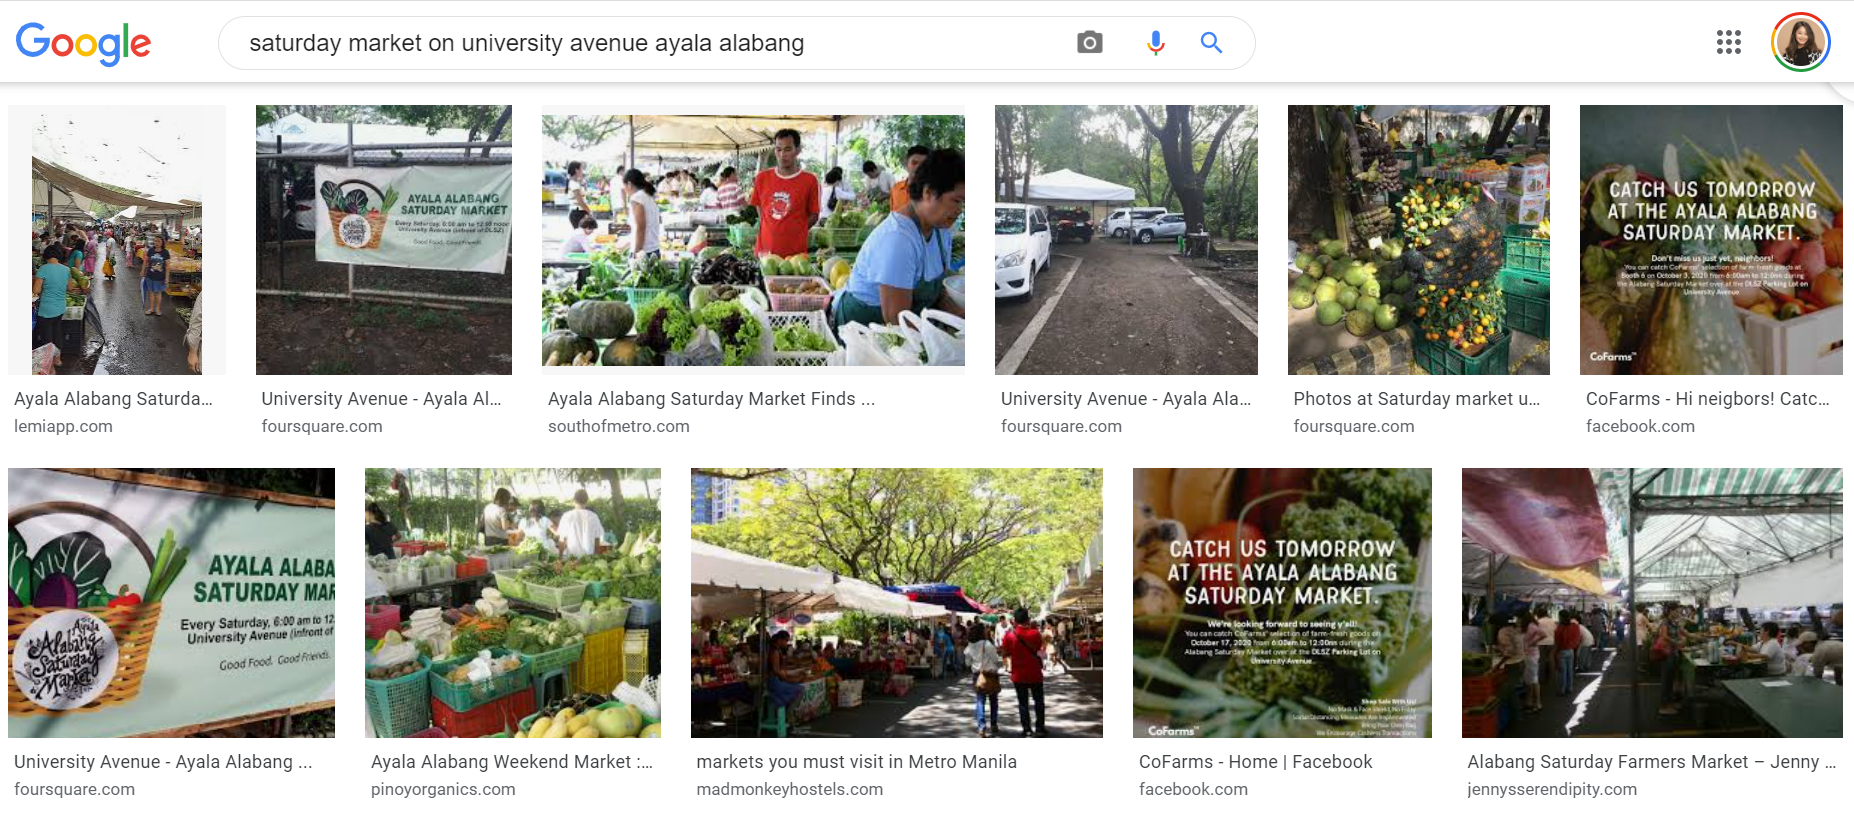

Now, I will repeat the same process for choosing the wet market suppliers for Clusters 2, 3, and 5.

### Finding wet market supplier candidates for Cluster 2
Because Cluster 2 only includes 3 villages, I picked one that wasn't the middle village to use as reference for finding wet markets near Cluster 2 (Serendra One), and this will be the first village to be delivered to.

In [19]:
#get latitude and longitude of Serendra One

address_2 = 'Serendra One, Metro Manila'

geolocator_2 = Nominatim(user_agent="2_agent")
location_2 = geolocator_2.geocode(address_2)
latitude_2 = location_2.latitude
longitude_2 = location_2.longitude
print(latitude_2, longitude_2)

14.55076185 121.05437323951678


In [20]:
#define the url to find wet markets near Cluster 2

url_2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_2, longitude_2,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url_2

'https://api.foursquare.com/v2/venues/search?client_id=RSC3G0GMLOJSBAD0PM1CDGKHBJIO441GM32W4RMZ4EG2HXFL&client_secret=QR5FE44FD3AKMH3HRHINEHH4FTOWIPROJB42S02G41NLQE3S&ll=14.55076185,121.05437323951678&oauth_token=AGWAV4YZA0YDWA1CIRQPDLXLXO0XUAC0YRBQ5EVYJTBLHA53&v=20180605&query=wet market&radius=2000&limit=100'

In [21]:
#get the results of wet markets near Cluster 2

results_2 = requests.get(url_2).json()
results_2

{'meta': {'code': 200, 'requestId': '6021f11ad7ffe01a4b7fb2f1'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '50fd2247e4b0d36cb20cddcd',
    'name': 'Guadalupe Wet Market',
    'location': {'address': 'Guadalupe',
     'lat': 14.562327360326895,
     'lng': 121.05019751017659,
     'labeledLatLngs': [{'label': 'display',
       'lat': 14.562327360326895,
       'lng': 121.05019751017659}],
     'distance': 1363,
     'cc': 'PH',
     'city': 'Makati City',
     'state': 'Makati City',
     'country': 'Pilipinas',
     'formattedAddress': ['Guadalupe', 'Makati', 'Makati City']},
    'categories': [{'id': '50be8ee891d4fa8dcc7199a7',
      'name': 'Market',
      'pluralName': 'Markets',
      'shortName': 'Market',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/market_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1612837146',
    'hasPerk': False},
   {'id': '4ec850e3f79

In [22]:
# assign relevant part of JSON to venues
venues_2 = results_2['response']['venues']

# tranform venues into a dataframe
df_results_2 = json_normalize(venues_2)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_2 = ['name', 'categories'] + [col for col in df_results_2.columns if col.startswith('location.')] + ['id']
df_markets_2 = df_results_2.loc[:, filtered_columns_2]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_markets_2['categories'] = df_markets_2.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_markets_2.columns = [column.split('.')[-1] for column in df_markets_2.columns]

df_markets_2

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


name  \
0                                Guadalupe Wet Market   
1                                  Pateros Wet Market   
2                Wet Market @ 21st Street, West Rembo   
3                                     Market! Market!   
4                             Market! Market! Parking   
5                                       Fiesta Market   
6             BGC Bus Stop (Market! Market! Terminal)   
7                     Market! Market! Activity Center   
8                      Market! Market! Farmers Market   
9     UV Express Terminal - Market! Market! - Rosario   
10       MDC 309 Taguig-Global Market Market McKinley   
11                      Market! Market! Fountain Area   
12                           Market Market Playground   
13                                     Fashion Market   
14   Sodexo Affiliate Store, Celine - Market! Market!   
15                 South of Market Private Residences   
16                       Reyes Barbecue Market Market   
17                                Guess market market   
18                        One Serendra - Market Lobby   
19                      Market! Market! Taxi Terminal   
20                           Market! Market! Terminal   
21                                   The Pearl Market   
22                                South of Market Gym   
23                              Merrell Market Market   
24                                telus market market   
25                       M Lhuillier - Marker!Market!   
26                           unica hija market market   
27                           South of Market Poolside   
28                   Market! Market! Jeepney Terminal   
29                       mercury drug market market 2   
30                     me & u gift shop market market   
31                        Sunnies Specs Market Market   
32                            Market! Market! Cinemas   
33                                Mint- Market Market   
34                               Market on 5th Avenue   
35                          Okonomiyaki Market Market   
36              TIP Market Market 5th fl smoking area   
37                   Peoples Champorado Fiesta Market   
38                           Atm Center Market Market   
39               Telus Market! Market! IP Essentials.   
40                     Citibank Savings Market Market   
41                             Sen-Lek, Market-Market   
42                          foodchoices market market   
43                  Cebuana Lhuillier, Market!Market!   
44                          R365P,Inc Market! Market!   
45     W5 Conference Room, Harte Hanks, Market Market   
46  Mojo Filter 1 Training Room, TELUS Market! Mar...   
47                           Elsie's, Market! Market!   
48                      Wendy's kiosk Market! Market!   
49  Learning And Development Office, Old Flat Top ...   

                                  categories  \
0                                     Market   
1                                     Market   
2                                Flea Market   
3                              Shopping Mall   
4                                    Parking   
5                                 Food Court   
6                                Bus Station   
7                                Event Space   
8                             Farmers Market   
9                             General Travel   
10                                  Pharmacy   
11                                  Fountain   
12                                Playground   
13                               Flea Market   
14                          Department Store   
15  Residential Building (Apartment / Condo)   
16                       Filipino Restaurant   
17                            Clothing Store   
18  Residential Building (Apartment / Condo)   
19                                Taxi Stand   
20                            General Travel   
21                          Department Store   
22                      Gym / Fitness

In [23]:
# add the wet markets as yellow circle markers
for lat, lng, label in zip(df_markets_2.lat, df_markets_2.lng, df_markets_2.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='yellow',
        popup=label,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(cluster_map)

# display map
cluster_map

As we can see here, there are many markets plotted near Cluster 2 because it is right next to a shopping mall called "Market! Market!" This might be one of the restrictions of using Foursquare API because even the non-food shops in the mall were included in the search results since their names had the word "Market" in them. Upon checking the nearby points though, it could be seen that there is also a __Farmers Market within the mall Market! Market!__, so this could be the potential supplier for Cluster 2.

Now I will check the rating of the Market! Market! Farmers Market.

In [24]:
#check the rating of Market! Market! Farmers Market

venue_id_MMFM = '5c7216bd840fc2002c16a73d' # Market! Market! Farmers Market
url_MMFM = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id_MMFM, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)

result_MMFM = requests.get(url_MMFM).json()

try:
    print(result_MMFM['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


Again, the venue has not been rated. Let's check if the venue has any tips which might help show feedback on this place.

In [25]:
## MMFM Tips
limit_MMFM = 15 # set limit to be greater than or equal to the total number of tips
tips_MMFM = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&oauth_token={}&v={}&limit={}'.format(venue_id_MMFM, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION, limit_MMFM)

results_MMFM = requests.get(tips_MMFM).json()
results_MMFM

{'meta': {'code': 200, 'requestId': '6021f11b0149401628498fca'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'tips': {'count': 0, 'items': []}}}

There are also no tips available on Foursquare API. Since this wet market and the next nearest wet markets (which were already a bit far from the cluster) do not have ratings too, I will base my decision to recommend Market! Market! Farmers Market as a supplier for Cluster 2 on photos of it that were found in Google Images.

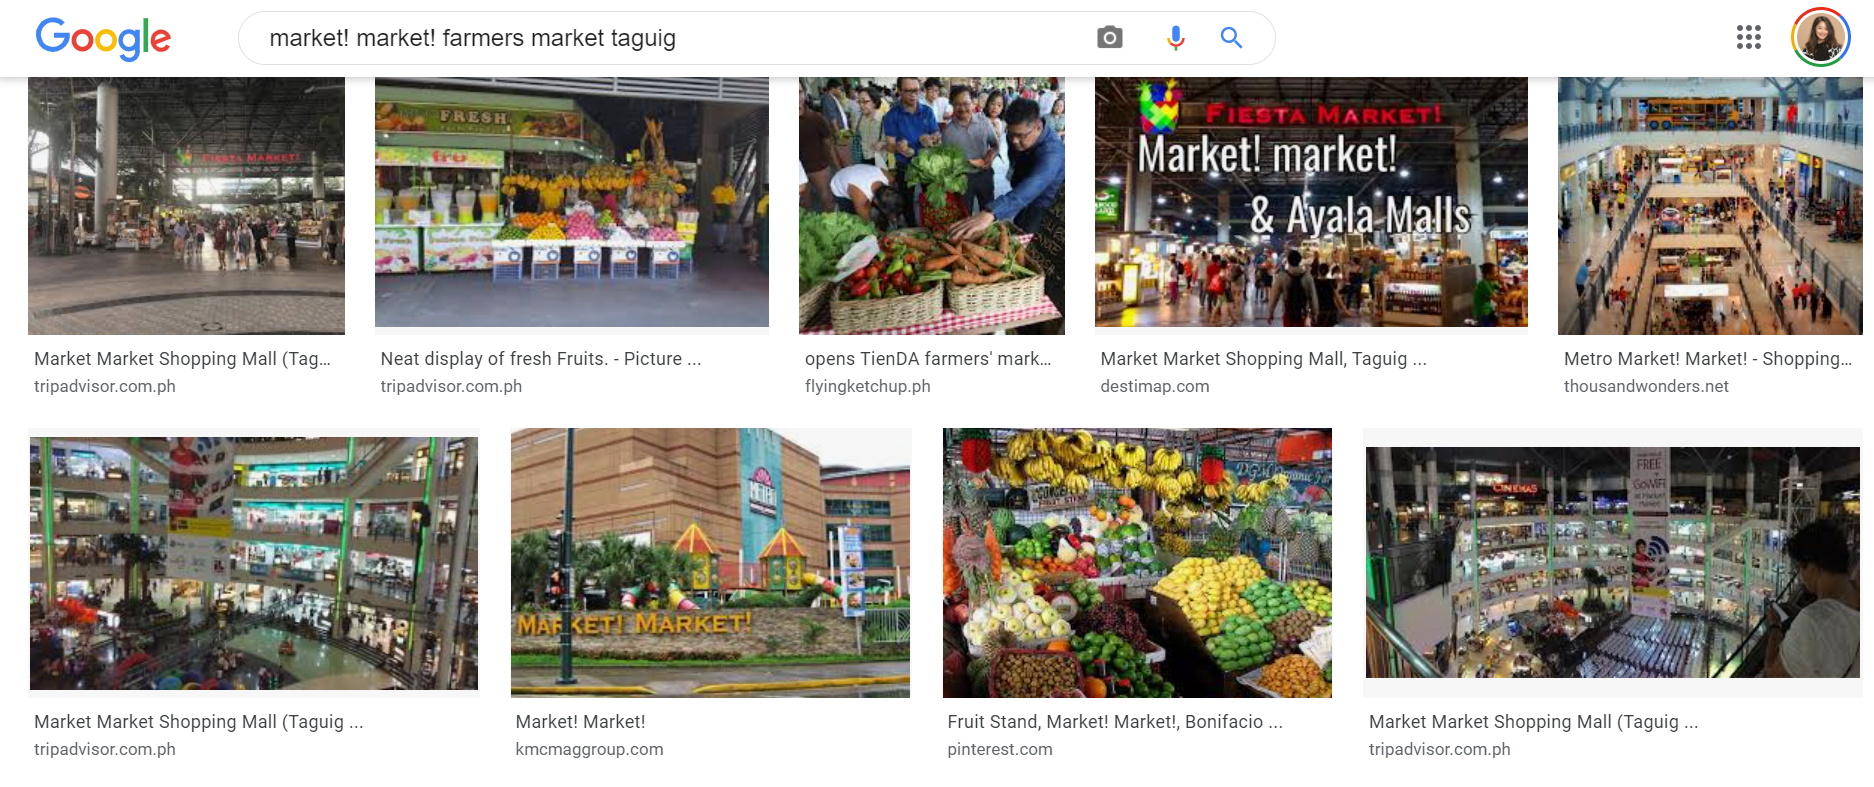

Based on the photos, this looks like a clean and reputable wet market, especially because it is located in an area of a popular shopping mall. Therefore, I will recommend __Market! Market! Farmers Market__ as a supplier for Cluster 2 residents.

Now, I will look for the best wet market supplier for Cluster 3. 

### Finding wet market supplier candidates for Cluster 3
Because Cluster 3 only includes 3 villages, I picked one that wasn't the middle village to use as reference for finding wet markets near Cluster 3, and this will be the first village to be delivered to. I specifically picked La Vista Village because the other two villages are a bit close to each other and are on one side of a river, so logistically, it's easier to deliver to La Vista first.

In [26]:
#get latitude and longitude of La Vista Village

address_3 = 'La Vista, Metro Manila'

geolocator_3 = Nominatim(user_agent="3_agent")
location_3 = geolocator_3.geocode(address_3)
latitude_3 = location_3.latitude
longitude_3 = location_3.longitude
print(latitude_3, longitude_3)

14.6385719 121.126406


In [27]:
#define the url to find wet markets near Cluster 3

url_3 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_3, longitude_3,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url_3

'https://api.foursquare.com/v2/venues/search?client_id=RSC3G0GMLOJSBAD0PM1CDGKHBJIO441GM32W4RMZ4EG2HXFL&client_secret=QR5FE44FD3AKMH3HRHINEHH4FTOWIPROJB42S02G41NLQE3S&ll=14.6385719,121.126406&oauth_token=AGWAV4YZA0YDWA1CIRQPDLXLXO0XUAC0YRBQ5EVYJTBLHA53&v=20180605&query=wet market&radius=2000&limit=100'

In [28]:
#get the results of wet markets near Cluster 3

results_3 = requests.get(url_3).json()
results_3

{'meta': {'code': 200, 'requestId': '6021f11ce4a0d416f03917cc'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4fb83768e4b0ee36afabe199',
    'name': 'Masinag Wet Market',
    'location': {'lat': 14.62549340975436,
     'lng': 121.12346504939873,
     'labeledLatLngs': [{'label': 'display',
       'lat': 14.62549340975436,
       'lng': 121.12346504939873}],
     'distance': 1489,
     'cc': 'PH',
     'country': 'Pilipinas'},
    'categories': [{'id': '4bf58dd8d48988d10e951735',
      'name': 'Fish Market',
      'pluralName': 'Fish Markets',
      'shortName': 'Fish Market',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_fishmarket_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1612837148',
    'hasPerk': False},
   {'id': '4f4c2c38e4b0accb031f4e7c',
    'name': 'Idol Wet & Dry Market',
    'location': {'lat': 14.628670692443848,
     'lng': 121.12205505371094,
  

In [29]:
# assign relevant part of JSON to venues
venues_3 = results_3['response']['venues']

# tranform venues into a dataframe
df_results_3 = json_normalize(venues_3)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_3 = ['name', 'categories'] + [col for col in df_results_3.columns if col.startswith('location.')] + ['id']
df_markets_3 = df_results_3.loc[:, filtered_columns_3]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_markets_3['categories'] = df_markets_3.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_markets_3.columns = [column.split('.')[-1] for column in df_markets_3.columns]

df_markets_3

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


name            categories        lat  \
0                Masinag Wet Market           Fish Market  14.625493   
1             Idol Wet & Dry Market           Flea Market  14.628671   
2         Molave Wet and Dry Market                Market  14.646197   
3                    Masinag Market                Market  14.625440   
4               Viaga Public Market                  None  14.640700   
5              Tumana Public Market                  None  14.637201   
6                     Taboan Market                Market  14.631034   
7                   Sumulong Market                Market  14.628974   
8          Concepcion Square Market                Market  14.642570   
9   Goldenbox Marketing Corporation                Office  14.646354   
10                       McDonald's  Fast Food Restaurant  14.625387   
11                    Molave Market           Flea Market  14.645223   
12                conception market              Building  14.653008   
13            baytree public.market                Market  14.653008   
14             Pagrai Public Market           Flea Market  14.628348   
15                       NGI Market          Neighborhood  14.653159   
16             Beer Depot Marketing      Storage Facility  14.623839   
17          I Fashion Marketing Co.                Office  14.656314   

           lng                                     labeledLatLngs  distance  \
0   121.123465  [{'label': 'display', 'lat': 14.62549340975436...      1489   
1   121.122055  [{'label': 'display', 'lat': 14.62867069244384...      1197   
2   121.112918  [{'label': 'display', 'lat': 14.64619741251854...      1682   
3   121.125017  [{'label': 'display', 'lat': 14.62543993486963...      1469   
4   121.126825  [{'label': 'display', 'lat': 14.6407, 'lng': 1...       241   
5   121.120153  [{'label': 'display', 'lat': 14.637201, 'lng':...       690   
6   121.121824  [{'label': 'display', 'lat': 14.631034, 'lng':...       973   
7   121.121908  [{'label': 'display', 'lat': 14.628974, 'lng':...      1173   
8   121.113858  [{'label': 'display', 'lat': 14.64257010729697...      1422   
9   121.112644  [{'label': 'display', 'lat': 14.64635406585173...      1716   
10  121.124676  [{'label': 'display', 'lat': 14.62538721373274...      1479   
11  121.113494  [{'label': 'display', 'lat': 14.64522336581898...      1575   
12  121.122917  [{'label': 'display', 'lat': 14.65300846099853...      1650   
13  121.122917  [{'label': 'display', 'lat': 14.65300846099853...      1650   
14  121.144999  [{'label': 'display', 'lat': 14.62834758924980...      2303   
15  121.122928  [{'label': 'display', 'lat': 14.65315878805169...      1666   
16  121.133698  [{'label': 'display', 'lat': 14.62383903852114...      1818   
17  121.115520  [{'label': 'display', 'lat': 14.65631423754961...      2296   

    cc    country                                   address           city  \
0   PH  Pilipinas                                       NaN            NaN   
1   PH  Pilipinas                                       NaN            NaN   
2   PH  Pilipinas      General Ordonez St. Marikina Heights  Marikina City   
3   PH  Pilipinas                                Marcos Hwy  Antipolo City   
4   PH  Pilipinas                                       NaN  Antipolo City   
5   PH  Pilipinas                                       NaN  Antipolo City   
6   PH  Pilipinas                                      Cebu            NaN   
7   PH  Pilipinas                                       NaN            NaN   
8   PH  Pilipinas                                       NaN  Marikina City   
9   PH  Pilipinas                                       NaN  Marikina City   
10  PH  Pilipinas                            Masinag Market  Antipolo City   
11  PH  Pilipinas                                       NaN            NaN   
12  PH  Pilipinas                                       NaN            NaN   
13  PH  Pilipinas                                       NaN         

In [30]:
# add the wet markets as yellow circle markers
for lat, lng, label in zip(df_markets_3.lat, df_markets_3.lng, df_markets_3.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='yellow',
        popup=label,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(cluster_map)

# display map
cluster_map

Based on the map, the nearest market to La Vista is the __Viaga Public Market.__ I will check if this has any ratings on Foursquare API.

In [31]:
#check the rating of Viaga Public Market

venue_id_VPM = '4df16a6218386ecb4e27b8d6' # Viaga Public Market
url_VPM = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id_VPM, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)

result_VPM = requests.get(url_VPM).json()

try:
    print(result_VPM['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


Since this venue does not have a rating, I checked the next nearest wet markets to see if they have ratings, tips, or photos. Unfortunately, none of them do. I tried checking Google Images for photos of __Viaga Public Market, Tumana Public Market, and Taboan Public Market__ (the next nearest wet markets to La Vista), but no images of these were available as well. 

I suppose that __there are not too many venues in Metro Manila (or even in the Philippines) with reviews, tips, and photos on Foursquare API just yet__. Either that, or __not too many people review and leave tips on wet markets in this area__. In this case, I will leave it to the user of this report to explore the suggested wet markets themselves and gauge whether these are suitable for their customers.

Lastly, I will repeat the process for Cluster 5.

### Finding wet market supplier candidates for Cluster 5
Because Urdaneta Village is generally in the center of Cluster 5, I used it as a reference for searching for the list of wet markets nearest to the cluster.

In [32]:
#get latitude and longitude of Urdaneta Village

address_5 = 'Urdaneta Village, Metro Manila'

geolocator_5 = Nominatim(user_agent="5_agent")
location_5 = geolocator_5.geocode(address_5)
latitude_5 = location_5.latitude
longitude_5 = location_5.longitude
print(latitude_5, longitude_5)

14.5554581 121.03004429349755


In [33]:
#define the url to find wet markets near Cluster 5

url_5 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_5, longitude_5,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url_5

'https://api.foursquare.com/v2/venues/search?client_id=RSC3G0GMLOJSBAD0PM1CDGKHBJIO441GM32W4RMZ4EG2HXFL&client_secret=QR5FE44FD3AKMH3HRHINEHH4FTOWIPROJB42S02G41NLQE3S&ll=14.5554581,121.03004429349755&oauth_token=AGWAV4YZA0YDWA1CIRQPDLXLXO0XUAC0YRBQ5EVYJTBLHA53&v=20180605&query=wet market&radius=2000&limit=100'

In [34]:
#get the results of wet markets near Cluster 5

results_5 = requests.get(url_5).json()
results_5

{'meta': {'code': 200, 'requestId': '6021f11dfcab6e35f351c3de'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '50cbc254e4b0d0701e405a55',
    'name': 'Wet Market sa M. Ocampo St.',
    'location': {'lat': 14.554268,
     'lng': 121.012069,
     'labeledLatLngs': [{'label': 'display',
       'lat': 14.554268,
       'lng': 121.012069}],
     'distance': 1941,
     'cc': 'PH',
     'country': 'Pilipinas'},
    'categories': [{'id': '4eb1bd1c3b7b55596b4a748f',
      'name': 'Filipino Restaurant',
      'pluralName': 'Filipino Restaurants',
      'shortName': 'Filipino',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/filipino_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1612837149',
    'hasPerk': False},
   {'id': '4f1ccb0ae4b0838233838c13',
    'name': 'Wet market',
    'location': {'address': 'Pasong tamo',
     'lat': 14.5666979,
     'lng': 121.0124289,
     'labeledLa

In [35]:
# assign relevant part of JSON to venues
venues_5 = results_5['response']['venues']

# tranform venues into a dataframe
df_results_5 = json_normalize(venues_5)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns_5 = ['name', 'categories'] + [col for col in df_results_5.columns if col.startswith('location.')] + ['id']
df_markets_5 = df_results_5.loc[:, filtered_columns_5]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_markets_5['categories'] = df_markets_5.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_markets_5.columns = [column.split('.')[-1] for column in df_markets_5.columns]

df_markets_5

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


name  \
0                         Wet Market sa M. Ocampo St.   
1                                          Wet market   
2                               Washington Wet Market   
3                                Guadalupe Wet Market   
4                          Tejeros Wet and Dry Market   
5                          Olympia Wet and Dry Market   
6   Ayala-Washington/Market! Market! Jeepney Terminal   
7                                          The Market   
8                                        Market Phils   
9                               Guordo's World Market   
10                            Poblacion Public Market   
11                                      Savana Market   
12                                Legazpi Active Park   
13                        Bonifacio Global City (BGC)   
14                           Salcedo Community Market   
15                             Organic Farmers Market   
16                               Market on 5th Avenue   
17                              Mara's Organic Market   
18             Ayala - Market Market Jeepney Terminal   
19       Cooked Food The Market Fresh Rustan's Makati   
20                                   Max's Restaurant   
21                     Polaris Rolling Produce Market   
22                       The Market at L.P Leviste st   
23                     Market Market Jeepney Terminal   
24                                      SHORTS MARKET   
25                                    Gourmand Market   
26              Market Philippines, Inc @philam tower   
27                           Kalayaan Talipapa Market   
28                            Savemore Market A Venue   
29                                   the market place   
30                                      Market Street   
31                                Bel-air Flea Market   
32                               Toledo Public Market   
33                           Tita Ope, Salcedo Market   
34                SM Savers Market (Pasong Tamo-EDSA)   
35                                     Central Square   
36                     SHYLIN - Dampa, Seaside Market   
37                                     Francis Market   
38                       Green Palette Salcedo Market   
39                            the grey market records   
40                                         The Market   
41                             Picole, Salcedo Market   
42                                     SM Supermarket   
43                Buma Seafoods Market and Restaurant   
44                             Guadalupe Night Market   
45                 MDC 348 Cainta Rublou Market Place   
46                           The Munchy Market Office   
47                                         The Market   
48                   Market! Market! Jeepney Terminal   
49                                   The Stock Market   

                       categories        lat         lng  \
0             Filipino Restaurant  14.554268  121.012069   
1                     Flea Market  14.566698  121.012429   
2              Miscellaneous Shop  14.555785  121.012060   
3                          Market  14.562327  121.050198   
4                          Market  14.571390  121.013296   
5                          Market  14.570688  121.020032   
6                  General Travel  14.550111  121.030267   
7                   Deli / Bodega  14.560123  121.025043   
8                          Office  14.557325  121.021975   
9                    Gourmet Shop  14.552137  121.020998   
10                    Flea Market  14.565184  121.033609   
11             Miscellaneous Shop  14.566711  121.013477   
12                           Park  14.554145  121.016829   
13                   Neighborhood  14.551145  121.049029   
14                 Farmers Market  14.559990  121.023140   
15                 Farmers Market  14.555337  121.016210   
16                          Diner  14.555566  121.048365   
17  Vegetarian / Vegan Restaurant  14.554242  121.014956   
1

In [36]:
# add the wet markets as yellow circle markers
for lat, lng, label in zip(df_markets_5.lat, df_markets_5.lng, df_markets_5.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='yellow',
        popup=label,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(cluster_map)

# display map
cluster_map

Looking at the map of Cluster 5, I noticed that many of the points plotted were not actually wet markets, as some were night markets or supermarkets. It might be best if the wet market supplier is close to at least one of the villages in the border of the cluster, such as Rockwell Makati which is on the top right corner of the cluster. This is so that the wet market supplier could be near an "entry point" of the delivery route for that group. 
The nearest points near Rockwell Makati are "Marketplace by Rustans," which is a high end supermarket, and "The Grid Food Market," a high-end food court. Since neither are real wet markets for fresh produce, I would recommend __Poblacion Public Market__ as a wet market supplier for this cluster because it is the next nearest point to Rockwell Makati.

Hopefully, this one has a rating available on Foursquare API.

In [37]:
#check the rating of Poblacion Public Market

venue_id_PPM = '4e759be9814ddff25ee5cdf4' # Poblacion Public Market
url_PPM = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id_PPM, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)

result_PPM = requests.get(url_PPM).json()

try:
    print(result_PPM['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


Again, since this venue has no ratings available, I will base the quality of this market on Google Images again. This was the only image of Poblacion Public Market that I was able to find: 

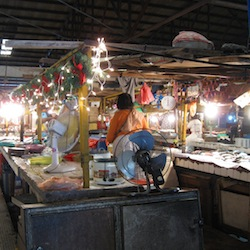

_Source_: http://simplegoodandtasty.com/2011/01/22/exploring-philippine-farmers-markets-with-an-eye-towards-the-twin-cities

Its interior is actually similar to that of Farmers Market Cubao, so I would assume that the produce in this wet market should be of similar quality too. Therefore, I would recommend Poblacion Public Market as the wet market supplier for Cluster 5.

# Conclusion

The 45 exclusive villages in Metro Manila were clustered into 6 delivery groups (Clusters 0-5) according to their proximity to each other. The groupings could be seen in the table below:

In [38]:
df_villages

Cluster Labels               Village   Latitude   Longitude
0                0            53 BENITEZ  14.614629  121.046274
1                4             ACROPOLIS  14.605744  121.077077
2                4             ALEXANDRA  14.580917  121.062601
3                5       APARTMENT RIDGE  14.556622  121.026340
4                1         AYALA ALABANG  14.405740  121.023723
5                3         AYALA HEIGHTS  14.662461  121.088204
6                1       AYALA SOUTHVALE  14.403211  121.011704
7                5               BEL-AIR  14.562216  121.026759
8                4    CORINTHIAN GARDENS  14.595673  121.063503
9                4      CORINTHIAN HILLS  14.596577  121.069272
10               5    DASMARINAS VILLAGE  14.540761  121.026191
11               0       EAST GREENHILLS  14.603023  121.046444
12               5           FORBES PARK  14.547168  121.035516
13               4          GREENMEADOWS  14.596545  121.076000
14               0     HORSESHOE VILLAGE  14.611544  121.039971
15               0           JADE GARDEN  14.606554  121.038915
16               3              LA VISTA  14.638572  121.126406
17               3   LOYOLA GRAND VILLAS  14.649698  121.087555
18               5            MAGALLANES  14.534482  121.015670
19               2         MCKINLEY HILL  14.533049  121.052429
20               0            NEW MANILA  14.612781  121.028906
21               0  NORTHEAST GREENHILLS  14.603023  121.046444
22               0      NORTH GREENHILLS  14.605751  121.045575
23               4           RENAISSANCE  14.581505  121.064023
24               5       ROCKWELL MAKATI  14.563414  121.037956
25               0    ROCKWELL THE GROVE  14.598197  121.036291
26               0         ROLLING HILLS  14.621309  121.020882
27               5           SAN LORENZO  14.546899  121.020945
28               5    SAN MIGUEL VILLAGE  14.567265  121.025519
29               2          SERENDRA ONE  14.550762  121.054373
30               2          SERENDRA TWO  14.546477  121.052850
31               4      SHINE RESIDENCES  14.582266  121.065124
32               5              URDANETA  14.555458  121.030044
33               0              VALENCIA  14.611590  121.035794
34               4         VALLE VERDE 1  14.575406  121.070287
35               4         VALLE VERDE 2  14.580798  121.074096
36               4         VALLE VERDE 3  14.582520  121.069121
37               4         VALLE VERDE 4  14.585873  121.069272
38               4         VALLE VERDE 5  14.586926  121.073930
39               4         VALLE VERDE 6  14.590828  121.076098
40               0              VIRIDIAN  14.601819  121.052299
41               4              VV HOMES  14.582494  121.075889
42               4        WACK-WACK ROAD  14.587722  121.052554
43               0     WACK-WACK VILLAGE  14.593470  121.042559
44               0       WEST GREENHILLS  14.603023  121.046444
45               4          WHITE PLAINS  14.606339  121.073432

Using Foursquare API and some additional human knowledge (like knowing the reputation of Farmers Market Cubao with the intended customers), I was able to identify some recommended wet markets where the target market could buy supplies which will be sold to the residents of these exclusive villages. These wet markets are:<br>
1. __Cluster 0__ (West Greenhills, Wack Wack Village, etc.) - __Farmers Market Cubao__<br>
2. __Cluster 1__ (Ayala Alabang, Ayala Southvale) - __Saturday Market on University Ave.__<br>
3. __Cluster 2__ (Serendra One, Serendra Two, and Mckinley Hill) - __Market! Market! Farmers Market__<br>
4. __Cluster 3__ (La Vista, Loyola Grand Villas, and Ayala Heights) - __Viaga Public Market, Tumana Public Market, or Taboan Public Market__<br>
5. __Cluster 4__ (Corinthian Gardens, Valle Verde 1, etc.) - __Farmers Market Cubao__<br>
6. __Cluster 5__ (Dasmarinas Village, Forbes Park, etc.) - __Poblacion Public Market__

I have also concluded through this project that __although this kind of data and technology are available for aiding in business decisions, a bulk of the analysis still relies on human experience and intuition__. For example, data from Foursquare could show us that certain venues tagged as wet markets would be the most practical choice as suppliers based on their proximity to the generated clusters, but this would not account for the savings a businessman could make by choosing the supplier that allows him to haggle for bulk orders.

At the end of the day, technology is a tool to make decision-making easier, but it can only be optimized by integrating it with real-world human knowledge.